In [9]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

#sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import mean_squared_error

#keras
from keras import layers, Input, Model
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM, BatchNormalization, Flatten
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers.convolutional import Conv1D, MaxPooling1D, AveragePooling1D
from keras.layers.experimental.preprocessing import Normalization


#others
import os
import json
from pathlib import Path
import joblib
import folium
import geojson
import geopandas as gpd
from statsmodels.tsa.arima_model import ARIMA
from xgboost import XGBRegressor, plot_importance, plot_tree

In [143]:
data = yf.download('NVDA AMD INTC', start='2014-01-01', end='2021-12-04', group_by='ticker')

[*********************100%***********************]  3 of 3 completed


In [144]:
data

AMD                                                  \
                  Open        High         Low       Close   Adj Close   
Date                                                                     
2014-01-02    3.850000    3.980000    3.840000    3.950000    3.950000   
2014-01-03    3.980000    4.000000    3.880000    4.000000    4.000000   
2014-01-06    4.010000    4.180000    3.990000    4.130000    4.130000   
2014-01-07    4.190000    4.250000    4.110000    4.180000    4.180000   
2014-01-08    4.230000    4.260000    4.140000    4.180000    4.180000   
...                ...         ...         ...         ...         ...   
2021-11-29  157.500000  162.509995  156.100006  161.910004  161.910004   
2021-11-30  163.279999  164.460007  155.679993  158.369995  158.369995   
2021-12-01  160.369995  160.880005  148.919998  149.110001  149.110001   
2021-12-02  147.679993  152.529999  146.470001  150.679993  150.679993   
2021-12-03  151.649994  152.380005  140.720001  144.009995  144.009995   

                            NVDA                                      \
              Volume        Open        High         Low       Close   
Date                                                                   
2014-01-02  20548400    3.980000    3.995000    3.930000    3.965000   
2014-01-03  22887200    3.972500    3.980000    3.905000    3.917500   
2014-01-06  42398300    3.957500    4.000000    3.920000    3.970000   
2014-01-07  42932100    4.010000    4.050000    3.982500    4.035000   
2014-01-08  30678700    4.050000    4.110000    4.035000    4.090000   
...              ...         ...         ...         ...         ...   
2021-11-29  57438900  323.660004  334.119995  320.359985  333.760010   
2021-11-30  75182500  331.690002  333.529999  318.640015  326.760010   
2021-12-01  64039100  332.190002  332.890015  313.799988  314.350006   
2021-12-02  56161200  312.140015  324.779999  310.250000  321.260010   
2021-12-03  65856800  320.000000  321.290009  301.299988  306.929993   

                                       INTC                                   \
             Adj Close    Volume       Open       High        Low      Close   
Date                                                                           
2014-01-02    3.745882  26009200  25.780001  25.820000  25.469999  25.790001   
2014-01-03    3.701007  25933200  25.860001  25.900000  25.600000  25.780001   
2014-01-06    3.750605  40949200  25.770000  25.790001  25.450001  25.459999   
2014-01-07    3.812013  33328800  25.540001  25.730000  25.469999  25.590000   
2014-01-08    3.863974  30819200  25.639999  25.709999  25.299999  25.430000   
...                ...       ...        ...        ...        ...        ...   
2021-11-29  333.719147  45496400  49.299999  50.130001  48.720001  50.000000   
2021-11-30  326.720001  62206600  49.500000  50.400002  48.680000  49.200001   
2021-12-01  314.350006  48436800  49.840000  50.310001  48.520000  48.599998   
2021-12-02  321.260010  47289000  48.610001  49.790001  48.330002  49.500000   
2021-12-03  306.929993  54382300  49.680000  50.060001  48.759998  49.250000   

                                 
            Adj Close    Volume  
Date                             
2014-01-02  20.678698  31833300  
2014-01-03  20.670677  27796700  
2014-01-06  20.414095  28682300  
2014-01-07  20.518333  19665100  
2014-01-08  20.390043  29680500  
...               ...       ...  
2021-11-29  50.000000  31478900  
2021-11-30  49.200001  49460800  
2021-12-01  48.599998  35093500  
2021-12-02  49.500000  37240800  
2021-12-03  49.250000  32221900  

[1996 rows x 18 columns]

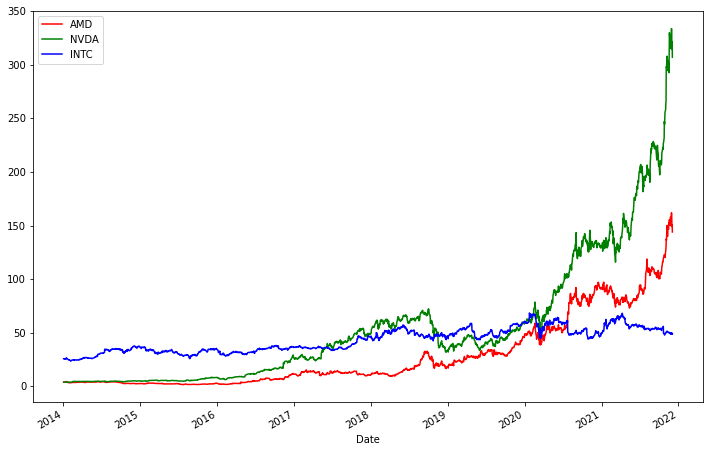

In [145]:
data['AMD']['Close'].plot(figsize=(12,8), color='red', label='AMD')
data['NVDA']['Close'].plot(color='green', label='NVDA')
data['INTC']['Close'].plot(color='blue', label='INTC')
plt.legend()

In [146]:
tickers_list = ['NVDA', 'AMD', 'INTC']
tickers_data = {}

for ticker in tickers_list:
    ticker_object = yf.Ticker(ticker)

    temp = pd.DataFrame.from_dict(ticker_object.info, orient='index')
    temp.reset_index(inplace=True)
    temp.columns = ['Attribute', 'Recent']

    tickers_data[ticker] = temp

tickers_data

{'NVDA':                Attribute                                             Recent
 0                    zip                                              95051
 1                 sector                                         Technology
 2      fullTimeEmployees                                              18975
 3    longBusinessSummary  NVIDIA Corporation operates as a visual comput...
 4                   city                                        Santa Clara
 ..                   ...                                                ...
 146        dividendYield                                             0.0005
 147              bidSize                                                900
 148              dayHigh                                             307.11
 149   regularMarketPrice                                             301.21
 150             logo_url               https://logo.clearbit.com/nvidia.com
 
 [151 rows x 2 columns],
 'AMD':                Attribute         

In [147]:
#full list of infos

#'zip', 'sector', 'fullTimeEmployees', 'longBusinessSummary', 'city', 'phone', 'state', 'country', 'companyOfficers', 'website', 'maxAge',
# 'address1', 'industry', 'previousClose', 'regularMarketOpen', 'twoHundredDayAverage', 'trailingAnnualDividendYield', 'payoutRatio', 'volume24Hr',
#  'regularMarketDayHigh', 'navPrice', 'averageDailyVolume10Day', 'totalAssets', 'regularMarketPreviousClose', 'fiftyDayAverage', 'trailingAnnualDividendRate',
#  'open', 'toCurrency', 'averageVolume10days', 'expireDate', 'yield', 'algorithm', 'dividendRate', 'exDividendDate', 'beta', 'circulatingSupply', 'startDate',
#  'regularMarketDayLow', 'priceHint', 'currency', 'trailingPE', 'regularMarketVolume', 'lastMarket', 'maxSupply', 'openInterest', 'marketCap', 'volumeAllCurrencies',
#  'strikePrice', 'averageVolume', 'priceToSalesTrailing12Months', 'dayLow', 'ask', 'ytdReturn', 'askSize', 'volume', 'fiftyTwoWeekHigh', 'forwardPE', 'fromCurrency',
#  'fiveYearAvgDividendYield', 'fiftyTwoWeekLow', 'bid', 'tradeable', 'dividendYield', 'bidSize', 'dayHigh', 'exchange', 'shortName', 'longName', 'exchangeTimezoneName',
#  'exchangeTimezoneShortName', 'isEsgPopulated', 'gmtOffSetMilliseconds', 'quoteType', 'symbol', 'messageBoardId', 'market', 'annualHoldingsTurnover', 'enterpriseToRevenue',
#  'beta3Year', 'profitMargins', 'enterpriseToEbitda', '52WeekChange', 'morningStarRiskRating', 'forwardEps', 'revenueQuarterlyGrowth', 'sharesOutstanding', 'fundInceptionDate',
#  'annualReportExpenseRatio', 'bookValue', 'sharesShort', 'sharesPercentSharesOut', 'fundFamily', 'lastFiscalYearEnd', 'heldPercentInstitutions', 'netIncomeToCommon',
#  'trailingEps', 'lastDividendValue', 'SandP52WeekChange', 'priceToBook', 'heldPercentInsiders', 'nextFiscalYearEnd', 'mostRecentQuarter', 'shortRatio',
#  'sharesShortPreviousMonthDate', 'floatShares', 'enterpriseValue', 'threeYearAverageReturn', 'lastSplitDate', 'lastSplitFactor', 'legalType', 'lastDividendDate',
#  'morningStarOverallRating', 'earningsQuarterlyGrowth', 'dateShortInterest', 'pegRatio', 'lastCapGain', 'shortPercentOfFloat', 'sharesShortPriorMonth',
#  'impliedSharesOutstanding', 'category', 'fiveYearAverageReturn', 'regularMarketPrice', 'logo_url'

In [148]:
combined_data = pd.concat(tickers_data)
combined_data = combined_data.reset_index()
combined_data = combined_data.drop(columns=['level_1'], axis=1)
combined_data.columns = ['Ticker', 'Attributes', 'Recent']
combined_data

#looking at the attributes of the 3 tickers (NVDA, AMD, INTC)

,Ticker,Attributes,Recent
0,NVDA,zip,95051
1,NVDA,sector,Technology
2,NVDA,fullTimeEmployees,18975
3,NVDA,longBusinessSummary,NVIDIA Corporation operates as a visual comput...
4,NVDA,city,Santa Clara
...,...,...,...
448,INTC,dividendYield,0.027
449,INTC,bidSize,1300
450,INTC,dayHigh,53.23
451,INTC,regularMarketPrice,53.21


In [149]:
combined_data['Attributes']

0                      zip
1                   sector
2        fullTimeEmployees
3      longBusinessSummary
4                     city
              ...         
448          dividendYield
449                bidSize
450                dayHigh
451     regularMarketPrice
452               logo_url
Name: Attributes, Length: 453, dtype: object

In [150]:
employees = combined_data[combined_data['Attributes'] == 'fullTimeEmployees']
employees.sort_values(by='Recent', ascending=False)

#INTC is a much bigger company relative in employees count

,Ticker,Attributes,Recent
304,INTC,fullTimeEmployees,117200
2,NVDA,fullTimeEmployees,18975
153,AMD,fullTimeEmployees,12600


In [151]:
market_cap = combined_data[combined_data['Attributes'] == 'marketCap'].drop(columns='Attributes', axis=1)
company_hq = combined_data[combined_data['Attributes'] == 'city'].drop(columns='Attributes', axis=1)
five_year_div_yield = combined_data[combined_data['Attributes'] == 'fiveYearAvgDividendYield'].drop(columns='Attributes', axis=1)
company_hq.columns = ['Ticker', 'City']
market_cap.columns = ['Ticker', 'Market Cap']
five_year_div_yield.columns = ['Ticker', 'Dividend Yield (5 Years)']

In [152]:
market_cap
#nvda 800bil
#amd 187bil
#intc 200bil

,Ticker,Market Cap
132,NVDA,750615330816
283,AMD,181431336960
434,INTC,216405065728


In [153]:
company_comparison = pd.merge(market_cap, company_hq, left_on='Ticker', right_on='Ticker')
company_comparison = pd.merge(company_comparison, five_year_div_yield, left_on='Ticker', right_on='Ticker')
company_comparison

#high dividend yield for INTC. No dividend for AMD

,Ticker,Market Cap,City,Dividend Yield (5 Years)
0,NVDA,750615330816,Santa Clara,0.25
1,AMD,181431336960,Santa Clara,None
2,INTC,216405065728,Santa Clara,2.48


In [154]:
heldInsiders = combined_data[combined_data['Attributes'] == 'heldPercentInsiders']
year_change = combined_data[combined_data['Attributes'] == '52WeekChange']


In [155]:
year_change_and_insiders = pd.merge(heldInsiders, year_change, on='Ticker')
year_change_and_insiders = year_change_and_insiders.rename(columns={'Recent_x': "insidersHeld", "Recent_y": "yearly_change"})
year_change_and_insiders

,Ticker,Attributes_x,insidersHeld,Attributes_y,yearly_change
0,NVDA,heldPercentInsiders,0.04079,52WeekChange,1.247039
1,AMD,heldPercentInsiders,0.00421,52WeekChange,0.619489
2,INTC,heldPercentInsiders,0.00073,52WeekChange,0.051373


<AxesSubplot:xlabel='insidersHeld', ylabel='yearly_change'>

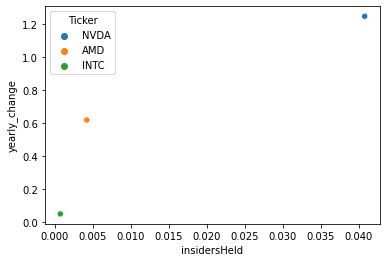

In [156]:
sns.scatterplot(data=year_change_and_insiders, x='insidersHeld', y='yearly_change', hue='Ticker')
#potentially looking at insiders holding for stocks to gauge the yearly_change

In [157]:
os.getcwd()

'c:\\Users\\huyho\\OneDrive\\Desktop\\stuff\\p-projects\\stock-forecasting'

In [158]:
#coordinates of intc, nvda, and amd HQ
latitude = [37.3860884556, 37.3691018569, 37.38242485333451]
longitude = [-121.958119501, -121.9582395, -121.97017259436115]
comp_ticker = ['INTC', 'NVDA', 'AMD']
color = ['blue', 'green', 'red'] 

t = zip(latitude, longitude, comp_ticker, color)
result_t = set(t)
result_t

{(37.3691018569, -121.9582395, 'NVDA', 'green'),
 (37.38242485333451, -121.97017259436115, 'AMD', 'red'),
 (37.3860884556, -121.958119501, 'INTC', 'blue')}

In [159]:
#given that they are all headquartered in Santa Clara, let's visualize the proximity of these companies

m = folium.Map([37.3541, -121.9552], zoom_start=12)

for lat, lon, ticker, color in result_t:
    folium.Marker([lat, lon], popup=ticker, icon=folium.Icon(color=color)).add_to(m)
m

In [160]:
nvda_table = data['NVDA']
nvda_table['Month'] = nvda_table['Open'].index.month
nvda_month_grouped = nvda_table.groupby('Month').mean()

amd_table = data['AMD']
amd_table['Month'] = amd_table['Open'].index.month
amd_month_grouped = amd_table.groupby('Month').mean()

intc_table = data['INTC']
intc_table['Month'] = intc_table['Open'].index.month
intc_month_grouped = intc_table.groupby('Month').mean()

intc_month_grouped

<ipython-input-160-3d10f01f01a9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nvda_table['Month'] = nvda_table['Open'].index.month
<ipython-input-160-3d10f01f01a9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amd_table['Month'] = amd_table['Open'].index.month
<ipython-input-160-3d10f01f01a9>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

,Open,High,Low,Close,Adj Close,Volume
Month,,,,,,
1,42.463148,43.017901,41.996975,42.496667,38.431226,3.470906e+07
2,43.011765,43.510654,42.551307,43.058889,39.273798,2.577163e+07
3,42.904057,43.660000,42.314514,42.972000,39.231479,3.082112e+07
4,44.498976,45.017289,43.961506,44.499157,40.624378,2.816236e+07
5,42.757798,43.185774,42.358095,42.792678,39.183768,2.311837e+07
6,43.275581,43.639070,42.816337,43.219477,39.612779,2.665397e+07
7,43.044706,43.443294,42.615588,43.063529,39.409491,2.866230e+07
8,41.382216,41.710398,41.018466,41.368238,38.005656,2.446561e+07
9,42.216951,42.618781,41.852317,42.262195,38.843816,2.512801e+07


<AxesSubplot:xlabel='Month', ylabel='Volume'>

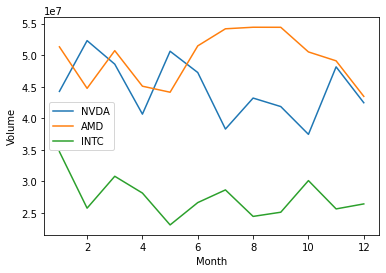

In [161]:
sns.lineplot(x=nvda_month_grouped['Volume'].index, y=nvda_month_grouped['Volume'], label='NVDA')
sns.lineplot(x=amd_month_grouped['Volume'].index, y=amd_month_grouped['Volume'], label='AMD')
sns.lineplot(x=intc_month_grouped['Volume'].index, y=intc_month_grouped['Volume'], label='INTC')
#volume seems to decrease significantly during the summer months

# Examine data before applying time-series

Common time-series data patterns:

- Level: The average value in the series
- Trend: Increases, decreases, stable
- Seasonal or Periodic: Does the pattern repeats over time
- Cyclical: Pattern that increases and decreases but usually related to non-seasonal activity, ie. business cycles
- Random or Irregular Variations: Increases and decreases that don't have any apparent patterns

<p2> The stock market prices probably falls into the Random and Irregular variations. For the model to be perfect, we must take into account financial records, social media activities, mergers and acquisitions, etc. Simply using previous prices will not yield a good model. However, we must work with the limited data that we possess.

In [162]:
import statsmodels.api as sm

In [163]:
def decomp():
    pass


# Using ARIMA

<p1> ARIMA models expect p, d, q as input parameters <p1>
1. p is the number of lag observations.
2. d is the degree of differencing.
3. q is the size/width of the moving average window. 


In [164]:
nvda = pd.DataFrame(data['NVDA']['Close'])
nvda.columns = ['Close']
nvda

,Close
Date,
2014-01-02,3.965000
2014-01-03,3.917500
2014-01-06,3.970000
2014-01-07,4.035000
2014-01-08,4.090000
...,...
2021-11-29,333.760010
2021-11-30,326.760010
2021-12-01,314.350006


In [165]:
#Before we can do ARIMA, we should look at the autocorrelation

from pandas.plotting import lag_plot

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 5)'>

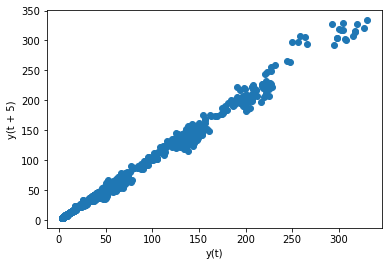

In [166]:
lag_plot(nvda['Close'], lag=5)

In [167]:
train_nvda, test_nvda = nvda[0:int(len(nvda) * 0.8)], nvda[int(len(nvda) * 0.8):]
print('training set shape', train_nvda.shape)
print('testing set shape', test_nvda.shape)

training set shape (1596, 1)
testing set shape (400, 1)


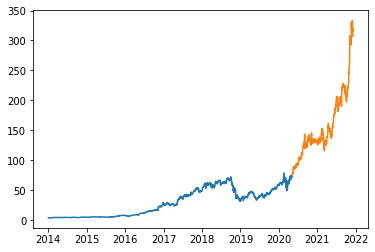

In [168]:
plt.plot(train_nvda)
plt.plot(test_nvda)

In [169]:
train_nvda, test_nvda = train_nvda.values, test_nvda.values

In [170]:
history = [x for x in train_nvda]
model_predictions = []
N_test_observations = len(test_nvda) #382

for time_point in range(N_test_observations):
    model = ARIMA(history, order=(4, 1, 0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test_nvda[time_point]
    history.append(true_test_value)

mse_error = mean_squared_error(test_nvda, model_predictions)
print('Testing MSE is', mse_error)

C:\Users\huyho\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


Testing MSE is 22.20696831902452


In [171]:
from matplotlib.pyplot import figure

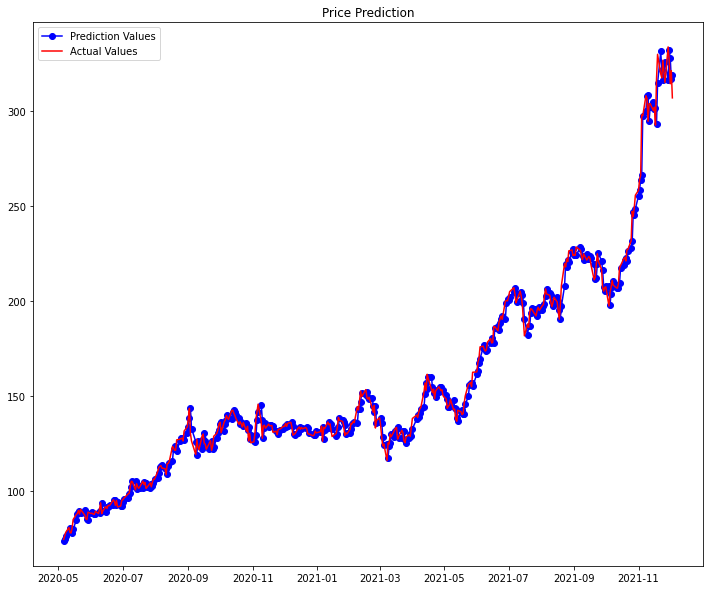

In [172]:
test_set_range = nvda[int(len(nvda) * 0.8):].index

plt.figure(figsize=(12,10))
plt.plot(test_set_range, model_predictions, color='blue', label='Prediction Values', marker='o')
plt.plot(test_set_range, test_nvda, color='red', label='Actual Values')

plt.title('Price Prediction')
plt.legend()
plt.show()

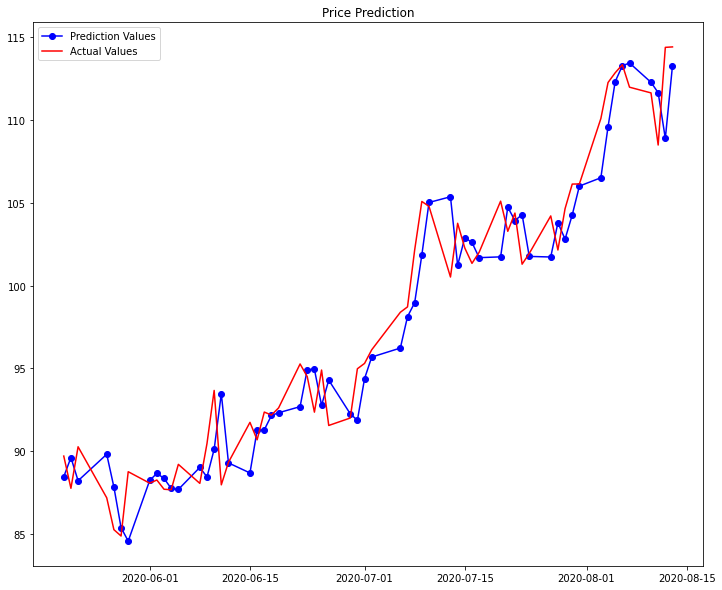

In [173]:
#looking at a smaller subset
plt.figure(figsize=(12,10))
plt.plot(test_set_range[10:70], model_predictions[10:70], color='blue', label='Prediction Values', marker='o')
plt.plot(test_set_range[10:70], test_nvda[10:70], color='red', label='Actual Values')

plt.title('Price Prediction')
plt.legend()
plt.show()

In [174]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [175]:
y_arima = train_nvda
y_arima

array([[ 3.96499991],
       [ 3.91750002],
       [ 3.97000003],
       ...,
       [70.69499969],
       [72.82250214],
       [73.43499756]])

In [176]:
armamodel = SARIMAX(y_arima, order = (1, 0,1))

In [177]:
armamodel = armamodel.fit()

C:\Users\huyho\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [178]:
y_pred_arma = armamodel.get_forecast(len(test_nvda))
y_pred_df = y_pred_arma.conf_int(alpha = 0.05)
y_pred_df

array([[ 71.09513862,  75.51754445],
       [ 70.36263692,  76.2199993 ],
       [ 69.77438154,  76.778214  ],
       [ 69.26776697,  77.25479403],
       [ 68.81553576,  77.67699686],
       [ 68.40289248,  78.05961791],
       [ 68.02074036,  78.41175397],
       [ 67.6630126 ,  78.7394718 ],
       [ 67.32542334,  79.04705729],
       [ 67.00481166,  79.33767135],
       [ 66.69876701,  79.61372453],
       [ 66.40540118,  79.87710503],
       [ 66.12320239,  80.12932464],
       [ 65.85093785,  80.37161614],
       [ 65.58758661,  80.60500049],
       [ 65.33229182,  80.83033452],
       [ 65.08432601,  81.04834571],
       [ 64.84306531,  81.25965795],
       [ 64.60796984,  81.46481108],
       [ 64.37856872,  81.66427599],
       [ 64.15444831,  81.85846633],
       [ 63.93524291,  82.04774781],
       [ 63.72062731,  82.23244561],
       [ 63.51031078,  82.41285047],
       [ 63.30403219,  82.58922352],
       [ 63.10155589,  82.76180041],
       [ 62.90266843,  82.93079459],
 

## ARIMA seems to do a pretty decent job. Of course there are instances where it might not be as reliable, for example during the market crash during the Covid-19 pandemic. However, it looks like a reliable model that is relatively simple to build.

# Using XGBOOST

In [46]:
xgboost_nvda = data['NVDA']

In [47]:
xgboost_nvda['target'] = xgboost_nvda['Close'].copy()
xgboost_nvda['target'] = xgboost_nvda['Close'].shift(-1)
xgboost_nvda.dropna(inplace=True)
xgboost_nvda

<ipython-input-47-e29f684a3415>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xgboost_nvda['target'] = xgboost_nvda['Close'].copy()
<ipython-input-47-e29f684a3415>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xgboost_nvda['target'] = xgboost_nvda['Close'].shift(-1)
<ipython-input-47-e29f684a3415>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

,Open,High,Low,Close,Adj Close,Volume,target
Date,,,,,,,
2014-01-02,3.980000,3.995000,3.930000,3.965000,3.745882,26009200,3.917500
2014-01-03,3.972500,3.980000,3.905000,3.917500,3.701007,25933200,3.970000
2014-01-06,3.957500,4.000000,3.920000,3.970000,3.750606,40949200,4.035000
2014-01-07,4.010000,4.050000,3.982500,4.035000,3.812014,33328800,4.090000
2014-01-08,4.050000,4.110000,4.035000,4.090000,3.863974,30819200,3.937500
...,...,...,...,...,...,...,...
2021-07-27,192.649994,196.220001,187.410004,192.080002,192.022629,24886300,195.029999
2021-07-28,193.190002,196.460007,189.949997,195.029999,194.971725,20219100,196.619995
2021-07-29,195.190002,198.529999,193.279999,196.619995,196.561264,19078100,194.990005


In [48]:
xgboost_nvda['target'][0] == xgboost_nvda['Close'][1]
#the target is the next date's closing price

True

In [49]:
xgboost_nvda_train, xgboost_nvda_test = xgboost_nvda[0:int(len(xgboost_nvda) * 0.8)], xgboost_nvda[int(len(xgboost_nvda) * 0.8):]
print('train length: ', len(xgboost_nvda_train))
print('test length: ', len(xgboost_nvda_test))

train length:  1527
test length:  382


In [50]:
train_X= xgboost_nvda_train.iloc[:, :-1]
train_Y= xgboost_nvda_train.iloc[:, -1]
test_X = xgboost_nvda_test.iloc[:, :-1]
test_Y = xgboost_nvda_test.iloc[:, -1]

In [51]:
train_X

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,3.980000,3.995000,3.930000,3.965000,3.745882,26009200
2014-01-03,3.972500,3.980000,3.905000,3.917500,3.701007,25933200
2014-01-06,3.957500,4.000000,3.920000,3.970000,3.750606,40949200
2014-01-07,4.010000,4.050000,3.982500,4.035000,3.812014,33328800
2014-01-08,4.050000,4.110000,4.035000,4.090000,3.863974,30819200
...,...,...,...,...,...,...
2020-01-21,61.952499,62.322498,61.642502,61.985001,61.828884,21791600
2020-01-22,62.439999,63.397499,62.250000,62.527500,62.370014,23924000
2020-01-23,62.930000,63.299999,62.037498,63.215000,63.055786,24451600


In [52]:
modelXGB = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
modelXGB.fit(train_X, train_Y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

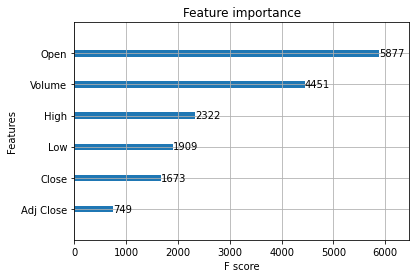

In [53]:
importance = plot_importance(modelXGB)

# Using Keras

In [201]:
nvda_train = nvda[:int(len(nvda) * 0.7)]
nvda_test = nvda[int(len(nvda) * 0.7):]
print('nvda train:' , len(nvda_train))
print('nvda test:' , len(nvda_test))

nvda train: 1397
nvda test: 599


In [202]:
display(nvda_train, nvda_test)

,Close
Date,
2014-01-02,3.965000
2014-01-03,3.917500
2014-01-06,3.970000
2014-01-07,4.035000
2014-01-08,4.090000
...,...
2019-07-16,41.770000
2019-07-17,42.427502
2019-07-18,42.544998


,Close
Date,
2019-07-23,43.915001
2019-07-24,44.665001
2019-07-25,43.345001
2019-07-26,43.767502
2019-07-29,43.705002
...,...
2021-11-29,333.760010
2021-11-30,326.760010
2021-12-01,314.350006


In [203]:
scaler = MinMaxScaler()
scaler.fit(nvda_train)

MinMaxScaler()

In [204]:
scaled_train = scaler.transform(nvda_train)
scaled_test = scaler.transform(nvda_test)

In [205]:
n_input = 300 #window size of 300
n_feature = 1 #univariate


#creating the generator for training and testing
train_generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)
test_generator = TimeseriesGenerator(scaled_test, scaled_test, length=n_input, batch_size=1)

In [206]:
#MODEL

model = Sequential()


model.add(Conv1D(filters=1024, kernel_size=3, activation='relu', padding='same', input_shape=(n_input, n_feature))) #(300, 1)
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=512, kernel_size=3, activation='relu', padding='same', input_shape=(n_input, n_feature))) #(300, 1)
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))

model.add(Flatten())
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=n_feature)) #1
model.compile(optimizer='adam', loss='mse')

#stochastic gradient descent sgd, mse is best for outlier detection

In [207]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 300, 1024)         4096      
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 150, 1024)         0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 150, 512)          1573376   
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 75, 512)           0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 75, 256)           393472    
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 37, 256)           0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 37, 128)          

In [208]:
model.fit(train_generator, epochs=5, batch_size=50, verbose=2)

Epoch 1/5
1097/1097 - 18s - loss: 0.0153
Epoch 2/5
1097/1097 - 17s - loss: 0.0019
Epoch 3/5
1097/1097 - 17s - loss: 0.0014
Epoch 4/5
1097/1097 - 17s - loss: 0.0028
Epoch 5/5
1097/1097 - 18s - loss: 0.0011


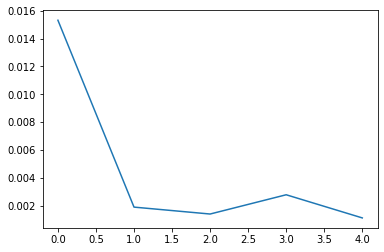

In [209]:
model_loss= model.history.history['loss']
plt.plot(range(len(model_loss)), model_loss)

In [210]:
test_predictions = []
train_predictions = []

#how far into the future will I forecast?
#loop through test window
for x,_ in test_generator:
    
    # One timestep ahead of historical 300 points
    current_pred = model.predict(x)
    
    #store that prediction
    test_predictions.append(current_pred[0])

#train window
for x,_ in train_generator:
    
    # One timestep ahead of historical 300 points
    current_pred_train = model.predict(x)
    
    #store that prediction
    train_predictions.append(current_pred_train[0])


#reverse the scaled into normal prices
train_predictions = scaler.inverse_transform(train_predictions)
true_predictions = scaler.inverse_transform(test_predictions)

In [211]:
test_result = nvda_test[n_input:]
test_result['predictions'] = true_predictions
test_result

<ipython-input-211-597e54aba391>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_result['predictions'] = true_predictions


,Close,predictions
Date,,
2020-09-29,132.257507,130.296935
2020-09-30,135.304993,132.628200
2020-10-01,136.145004,135.567117
2020-10-02,130.622498,137.382676
2020-10-05,136.425003,134.299860
...,...,...
2021-11-29,333.760010,309.541688
2021-11-30,326.760010,315.059800
2021-12-01,314.350006,318.057381


In [212]:
import seaborn as sns 

<AxesSubplot:xlabel='Date', ylabel='Close'>

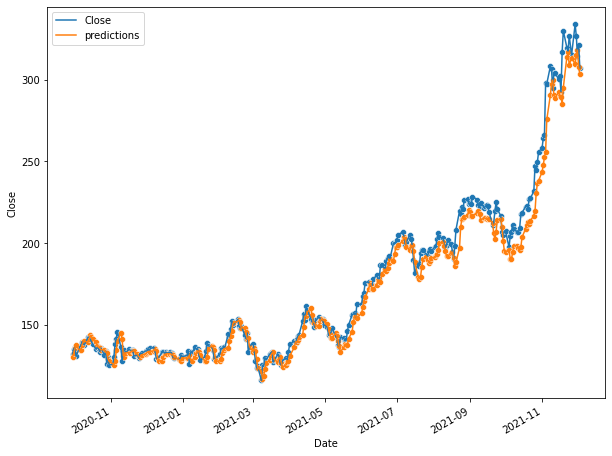

In [213]:
test_result[['Close', 'predictions']].plot(figsize=(10,8))
sns.scatterplot(x=test_result.index, y=test_result.Close)
sns.scatterplot(x=test_result.index, y=test_result.predictions)

<AxesSubplot:xlabel='Date'>

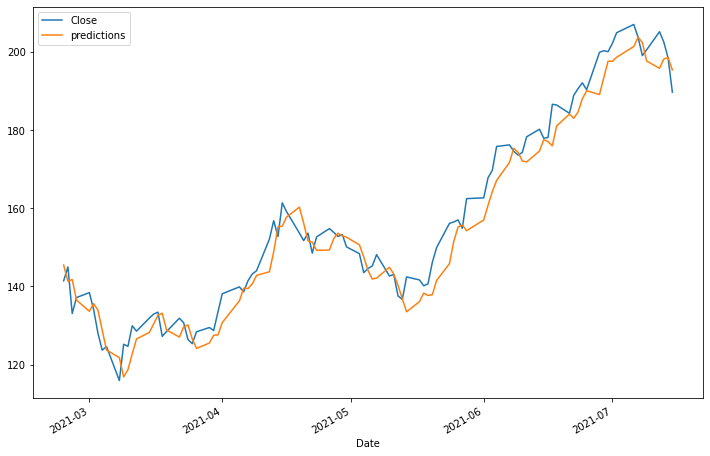

In [214]:
#looking at a smaller subset
test_result[['Close', 'predictions']][100:200].plot(figsize=(12,8))

In [215]:
#train results
train_result = nvda_train[n_input:]
train_result['predictions'] = train_predictions
train_result

<ipython-input-215-8e83d9a31f84>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_result['predictions'] = train_predictions


,Close,predictions
Date,,
2015-03-13,5.675000,5.575783
2015-03-16,5.742500,5.590925
2015-03-17,5.812500,5.606377
2015-03-18,5.717500,5.624296
2015-03-19,5.805000,5.631515
...,...,...
2019-07-16,41.770000,40.050824
2019-07-17,42.427502,40.018969
2019-07-18,42.544998,40.383055


<AxesSubplot:xlabel='Date'>

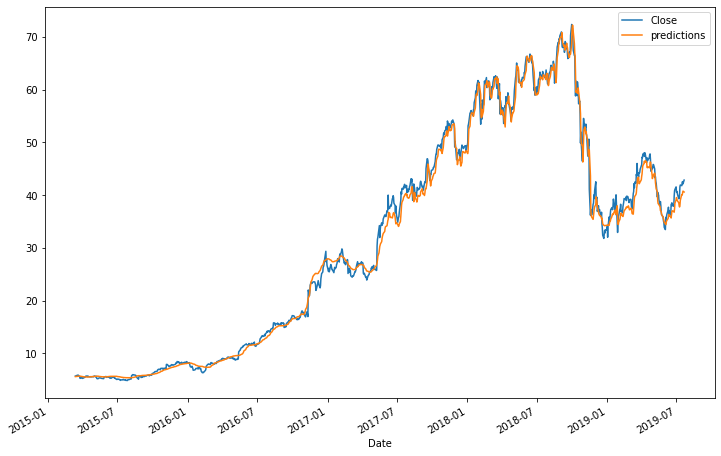

In [216]:
train_result.plot(figsize=(12,8))

<AxesSubplot:xlabel='Date'>

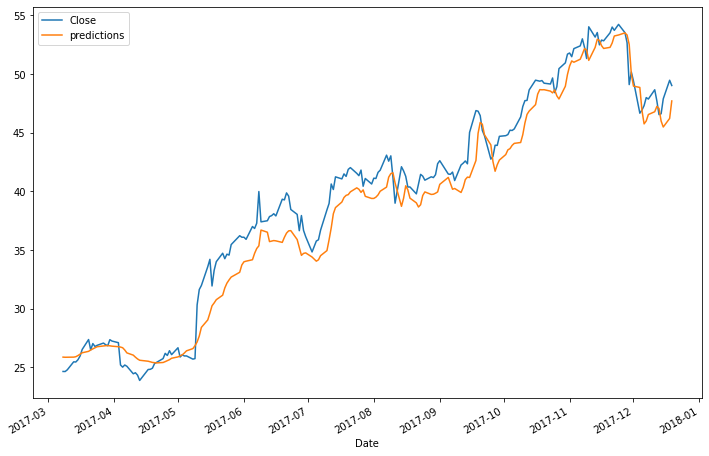

In [217]:
train_result[500:700].plot(figsize=(12,8))

In [218]:
test_result

,Close,predictions
Date,,
2020-09-29,132.257507,130.296935
2020-09-30,135.304993,132.628200
2020-10-01,136.145004,135.567117
2020-10-02,130.622498,137.382676
2020-10-05,136.425003,134.299860
...,...,...
2021-11-29,333.760010,309.541688
2021-11-30,326.760010,315.059800
2021-12-01,314.350006,318.057381


In [219]:
mse = mean_squared_error(y_true=test_result['Close'], y_pred=test_result['predictions'])
mse
#mse of ~90 is decent.

66.37248220176399

This machine learning techniques using Keras can be quite inconsistent. Sometimes when I run it, the results would differ from another. Nevertheless, it is quite good and can be trained relatively quickly. 

#test

LET'S TEST ON AMD DATA

In [73]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 300, 512)          2048      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 150, 512)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 150, 256)          393472    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 75, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 75, 128)           98432     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 37, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 37, 64)            2

In [74]:
amd = pd.DataFrame(data['AMD']['Close'])
amd.columns = ['Close']
amd

,Close
Date,
2014-01-02,3.950000
2014-01-03,4.000000
2014-01-06,4.130000
2014-01-07,4.180000
2014-01-08,4.180000
...,...
2021-07-28,97.930000
2021-07-29,102.949997
2021-07-30,106.190002


In [75]:
amd_train = amd[:int(len(amd) * 0.7)]
amd_test = amd[int(len(amd) * 0.7):]
scaler.fit(amd_train)
scaled_train_amd = scaler.transform(amd_train)
scaled_test_amd = scaler.transform(amd_test)
n_input = 300 #window size of 300
n_feature = 1 #univariate


#creating the generator for training and testing
train_generator_amd = TimeseriesGenerator(scaled_train_amd, scaled_train_amd, length=n_input, batch_size=1)
test_generator_amd = TimeseriesGenerator(scaled_test_amd, scaled_test_amd, length=n_input, batch_size=1)
model.fit(train_generator_amd, epochs=5, batch_size=50, verbose=2)


test_predictions = []
train_predictions = []

#how far into the future will I forecast?
#loop through test window
for x,_ in test_generator_amd:
    
    # One timestep ahead of historical 300 points
    current_pred = model.predict(x)
    
    #store that prediction
    test_predictions.append(current_pred[0])

#train window
for x,_ in train_generator_amd:
    
    # One timestep ahead of historical 300 points
    current_pred_train = model.predict(x)
    
    #store that prediction
    train_predictions.append(current_pred_train[0])


#reverse the scaled into normal prices
train_predictions = scaler.inverse_transform(train_predictions)
true_predictions = scaler.inverse_transform(test_predictions)

Epoch 1/5
1037/1037 - 6s - loss: 0.0014
Epoch 2/5
1037/1037 - 6s - loss: 0.0012
Epoch 3/5
1037/1037 - 6s - loss: 0.0012
Epoch 4/5
1037/1037 - 6s - loss: 8.0750e-04
Epoch 5/5
1037/1037 - 6s - loss: 7.6682e-04


KeyboardInterrupt: 

In [78]:
amd_train = amd[:int(len(amd) * 0.7)]
amd_test = amd[int(len(amd) * 0.7):]
scaler.fit(amd_train)
scaled_train_amd = scaler.transform(amd_train)
scaled_test_amd = scaler.transform(amd_test)
n_input = 300 #window size of 300
n_feature = 1 #univariate


#creating the generator for training and testing
train_generator_amd = TimeseriesGenerator(scaled_train_amd, scaled_train_amd, length=n_input, batch_size=1)
test_generator_amd = TimeseriesGenerator(scaled_test_amd, scaled_test_amd, length=n_input, batch_size=1)


test_predictions = []
train_predictions = []

#how far into the future will I forecast?
#loop through test window
for x,_ in test_generator_amd:
    
    # One timestep ahead of historical 300 points
    current_pred = model.predict(x)
    
    #store that prediction
    test_predictions.append(current_pred[0])

#train window
for x,_ in train_generator_amd:
    
    # One timestep ahead of historical 300 points
    current_pred_train = model.predict(x)
    
    #store that prediction
    train_predictions.append(current_pred_train[0])


#reverse the scaled into normal prices
train_predictions = scaler.inverse_transform(train_predictions)
true_predictions = scaler.inverse_transform(test_predictions)

In [79]:
test_result = amd_test[300:]
test_result['predictions'] = true_predictions
test_result

<ipython-input-79-92a11d3c062f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_result['predictions'] = true_predictions


,Close,predictions
Date,,
2020-07-06,53.400002,47.210068
2020-07-07,52.930000,48.470925
2020-07-08,53.430000,47.663603
2020-07-09,57.259998,47.557790
2020-07-10,55.880001,49.661159
...,...,...
2021-07-28,97.930000,81.539868
2021-07-29,102.949997,85.949527
2021-07-30,106.190002,93.217495


<AxesSubplot:xlabel='Date', ylabel='Close'>

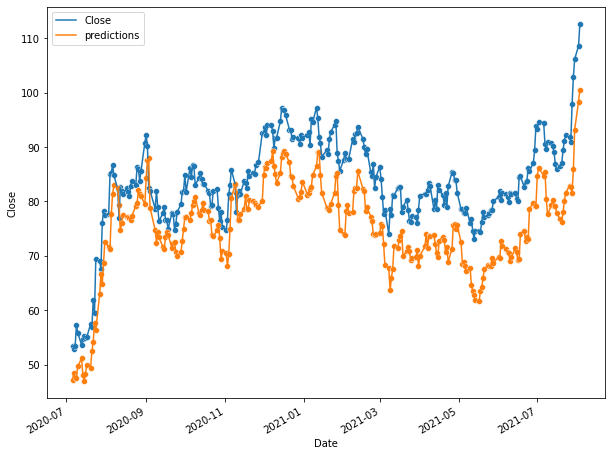

In [80]:
test_result[['Close', 'predictions']].plot(figsize=(10,8))
sns.scatterplot(x=test_result.index, y=test_result.Close)
sns.scatterplot(x=test_result.index, y=test_result.predictions)

In [81]:
train_result = amd_train[300:]
train_result['predictions'] = train_predictions
train_result

<ipython-input-81-138e62ede1fc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_result['predictions'] = train_predictions


,Close,predictions
Date,,
2015-03-13,2.750000,2.807566
2015-03-16,2.760000,2.771375
2015-03-17,2.770000,2.739966
2015-03-18,2.750000,2.713438
2015-03-19,2.740000,2.698888
...,...,...
2019-04-18,27.680000,27.523901
2019-04-22,28.180000,27.736680
2019-04-23,27.969999,28.204870


<AxesSubplot:xlabel='Date'>

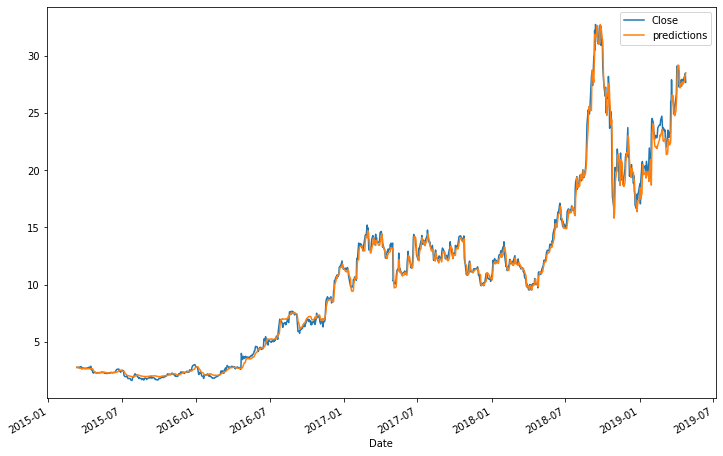

In [84]:
train_result.plot(figsize=(12,8))

In [85]:
test_aapl = yf.download('AAPL', start='2014-01-01', end='2021-08-04')
df_aapl = pd.DataFrame(test_aapl['Close'])
df_aapl.columns = ['Close']
df_aapl

[*********************100%***********************]  1 of 1 completed


,Close
Date,
2014-01-02,19.754642
2014-01-03,19.320715
2014-01-06,19.426071
2014-01-07,19.287144
2014-01-08,19.409286
...,...
2021-07-28,144.979996
2021-07-29,145.639999
2021-07-30,145.860001


In [87]:
aapl_train = df_aapl[:int(len(df_aapl) * 0.7)]
aapl_test = df_aapl[int(len(df_aapl) * 0.7):]
scaler.fit(aapl_train)
scaled_train_aapl = scaler.transform(aapl_train)
scaled_test_aapl = scaler.transform(aapl_test)
n_input = 300 #window size of 300
n_feature = 1 #univariate


#creating the generator for training and testing
train_generator_aapl = TimeseriesGenerator(scaled_train_aapl, scaled_train_aapl, length=n_input, batch_size=1)
test_generator_aapl = TimeseriesGenerator(scaled_test_aapl, scaled_test_aapl, length=n_input, batch_size=1)

test_predictions = []
train_predictions = []

#how far into the future will I forecast?
#loop through test window
for x,_ in test_generator_aapl:
    
    # One timestep ahead of historical 300 points
    current_pred = model.predict(x)
    
    #store that prediction
    test_predictions.append(current_pred[0])

#train window
for x,_ in train_generator_aapl:
    
    # One timestep ahead of historical 300 points
    current_pred_train = model.predict(x)
    
    #store that prediction
    train_predictions.append(current_pred_train[0])


#reverse the scaled into normal prices
train_predictions = scaler.inverse_transform(train_predictions)
true_predictions = scaler.inverse_transform(test_predictions)

In [88]:
test_result = aapl_test[300:]
test_result['predictions'] = true_predictions
test_result

<ipython-input-88-bddcba66409e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_result['predictions'] = true_predictions


,Close,predictions
Date,,
2020-07-06,93.462502,85.483627
2020-07-07,93.172501,87.560176
2020-07-08,95.342499,88.184476
2020-07-09,95.752502,90.036672
2020-07-10,95.919998,90.531494
...,...,...
2021-07-28,144.979996,136.407881
2021-07-29,145.639999,134.728102
2021-07-30,145.860001,134.698270


<AxesSubplot:xlabel='Date', ylabel='Close'>

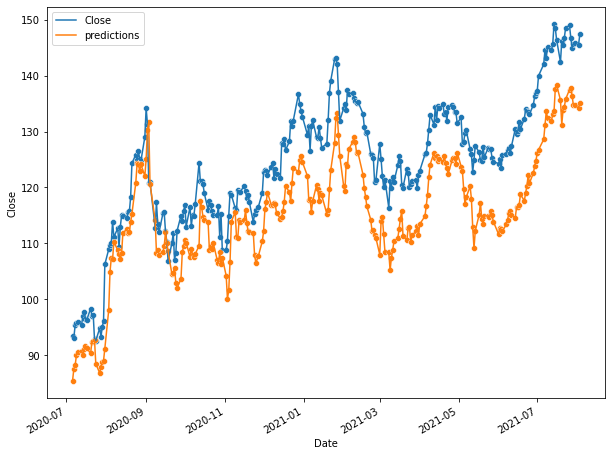

In [89]:
test_result[['Close', 'predictions']].plot(figsize=(10,8))
sns.scatterplot(x=test_result.index, y=test_result.Close)
sns.scatterplot(x=test_result.index, y=test_result.predictions)

In [90]:
train_result = aapl_train[300:]
train_result['predictions'] = train_predictions
train_result

<ipython-input-90-e7fa2b468363>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_result['predictions'] = train_predictions


,Close,predictions
Date,,
2015-03-13,30.897499,30.548926
2015-03-16,31.237499,30.666474
2015-03-17,31.760000,30.957872
2015-03-18,32.117500,31.472299
2015-03-19,31.875000,31.985781
...,...,...
2019-04-18,50.965000,50.117162
2019-04-22,51.132500,50.554048
2019-04-23,51.869999,50.732584


In [91]:
mse = mean_squared_error(y_true=test_result['Close'], y_pred=test_result['predictions'])
mse

92.05217555391691

<AxesSubplot:xlabel='Date'>

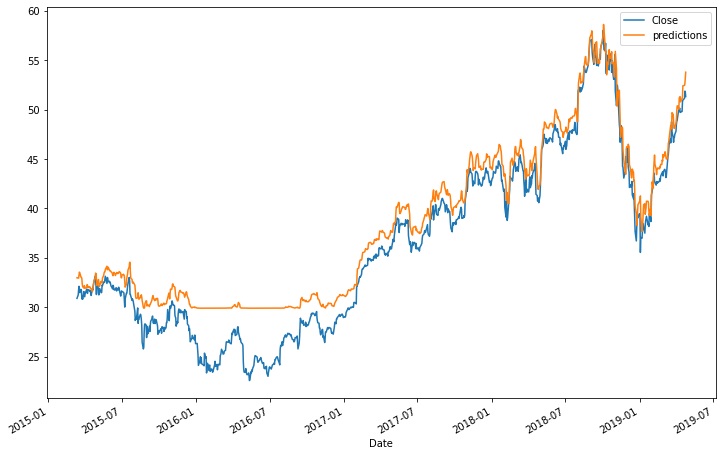

In [ ]:
train_result.plot(figsize=(12,8))

In [ ]:
def grab_ticker(ticker):
    data = yf.download(ticker, start='2014-01-01', end='2021-08-04')
    return data
    

In [ ]:
def get_closing_df(ticker):
    data = grab_ticker(ticker)
    df = pd.DataFrame(data['Close'])
    df.columns = ['Close']
    return df

In [ ]:
class Model:
    def build_model(self):
        df = get_closing_df('NVDA')
        n_input = 300
        n_feature = 1
        
        self.ticker_train = df[:int(len(df) * 0.7)]
        self.ticker_test = df[int(len(df) * 0.7):]
        
        scaler = MinMaxScaler()
        scaler.fit(self.ticker_train)
        scaled_train_ticker = scaler.transform(self.ticker_train)
        scaled_test_ticker = scaler.transform(self.ticker_test)
        
        #creating the generator for training and testing
        train_generator_ticker = TimeseriesGenerator(scaled_train_ticker, scaled_train_ticker, length=n_input, batch_size=1)
        test_generator_ticker = TimeseriesGenerator(scaled_test_ticker, scaled_test_ticker, length=n_input, batch_size=1)
        
        self.model = Sequential()

        self.model.add(Conv1D(filters=512, kernel_size=3, activation='relu', padding='same', input_shape=(n_input, n_feature))) #(300, 1)
        self.model.add(MaxPooling1D(pool_size=2))

        self.model.add(Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'))
        self.model.add(MaxPooling1D(pool_size=2))

        self.model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
        self.model.add(MaxPooling1D(pool_size=2))

        self.model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))

        self.model.add(Flatten())
        self.model.add(Dense(units=32, activation='relu'))
        self.model.add(Dense(units=n_feature)) #1
        self.model.compile(optimizer='adam', loss='mse')
        self.model.fit(train_generator_ticker, epochs=5, batch_size=50, verbose=2)

        #stochastic gradient descent sgd, mse is best for outlier detection
        return self.model
    

In [ ]:
a = Model()

In [8]:
a.build_model()

NameError: name 'yf' is not defined

In [87]:
class PreProcessed:
    
    def __init__(self, ticker):
        self.ticker = ticker
        self.n_input = 300
        self.n_feature = 1
        
    def build_model(self):
        self.model = Sequential()

        self.model.add(Conv1D(filters=512, kernel_size=3, activation='relu', padding='same', input_shape=(n_input, n_feature))) #(300, 1)
        self.model.add(MaxPooling1D(pool_size=2))

        self.model.add(Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'))
        self.model.add(MaxPooling1D(pool_size=2))

        self.model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
        self.model.add(MaxPooling1D(pool_size=2))

        self.model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))

        self.model.add(Flatten())
        self.model.add(Dense(units=32, activation='relu'))
        self.model.add(Dense(units=n_feature)) #1
        self.model.compile(optimizer='adam', loss='mse')

        #stochastic gradient descent sgd, mse is best for outlier detection
        return self.model
    
    def preprocessed_data(self):
        
        df = get_closing_df(ticker)
        self.ticker_train = df[:int(len(df) * 0.7)]
        self.ticker_test = df[int(len(df) * 0.7):]
        scaler = MinMaxScaler()
        scaler.fit(self.ticker_train)
        scaled_train_ticker = scaler.transform(self.ticker_train)
        scaled_test_ticker = scaler.transform(self.ticker_test)
        
        #creating the generator for training and testing
        train_generator_ticker = TimeseriesGenerator(scaled_train_ticker, scaled_train_ticker, length=n_input, batch_size=1)
        test_generator_ticker = TimeseriesGenerator(scaled_test_ticker, scaled_test_ticker, length=n_input, batch_size=1)
        
        
        test_predictions = []
        train_predictions = []

        #how far into the future will I forecast?
        #loop through test window
        for x,_ in test_generator_ticker:
            
            # One timestep ahead of historical 300 points
            current_pred = self.model.predict(x)
            
            #store that prediction
            test_predictions.append(current_pred[0])

        #train window
        for x,_ in train_generator_ticker:
            
            # One timestep ahead of historical 300 points
            current_pred_train = self.model.predict(x)
            
            #store that prediction
            train_predictions.append(current_pred_train[0])


        #reverse the scaled into normal prices
        self.train_predictions = scaler.inverse_transform(train_predictions)
        self.true_predictions = scaler.inverse_transform(test_predictions)
    
    def get_results(self):
        self.test_result = self.ticker_test[300:]
        self.test_result['predictions'] = self.true_predictions
        return self.test_result
        
    def plot_test_result_graph(self):
        self.test_result[['Close', 'predictions']].plot(figsize=(10,8))
        sns.scatterplot(x=self.test_result.index, y=self.test_result.Close).set(title='{} Result Predictions'.format(self.ticker))
        sns.scatterplot(x=self.test_result.index, y=self.test_result.predictions)
        
    def plot_train_result_graph(self):
        self.train_result = self.ticker_train[300:]
        self.train_result['predictions'] = self.train_predictions
        self.train_result.plot(figsize=(12,8))
        plt.title('{} Training Predictions'.format(self.ticker))
    
    def predict(self, target):
        df = get_closing_df(target)
        df_train = df[:int(len(df) * 0.7)]
        df_test = df[int(len(df) * 0.7):]
        scaler.fit(df_train)
        scaled_train_df = scaler.transform(df_train)
        scaled_test_df = scaler.transform(df_test)
        n_input = 300 #window size of 300
        n_feature = 1 #univariate


        #creating the generator for training and testing
        train_generator_df = TimeseriesGenerator(scaled_train_df, scaled_train_df, length=n_input, batch_size=1)
        test_generator_df = TimeseriesGenerator(scaled_test_df, scaled_test_df, length=n_input, batch_size=1)

        test_predictions = []
        train_predictions = []

        #how far into the future will I forecast?
        #loop through test window
        for x,_ in test_generator_df:
            
            # One timestep ahead of historical 300 points
            current_pred = self.model.predict(x)
            
            #store that prediction
            test_predictions.append(current_pred[0])

        #train window
        for x,_ in train_generator_df:
            
            # One timestep ahead of historical 300 points
            current_pred_train = self.model.predict(x)
            
            #store that prediction
            train_predictions.append(current_pred_train[0])


        #reverse the scaled into normal prices
        self.train_predictions = scaler.inverse_transform(train_predictions)
        self.test_predictions = scaler.inverse_transform(test_predictions)
        
        test_result = df_test[300:]
        test_result['predictions'] = self.test_predictions
        print(test_result)
        
        test_result[['Close', 'predictions']].plot(figsize=(10,8))
        sns.scatterplot(x=test_result.index, y=test_result.Close)
        sns.scatterplot(x=test_result.index, y=test_result.predictions)
        mse = mean_squared_error(y_true=test_result['Close'], y_pred=test_result['predictions'])
        print('MSE is: {}'.format(mse))
        

In [88]:
p = PreProcessed('NVDA')

In [89]:
p.build_model()

In [90]:
p.preprocessed_data()

[*********************100%***********************]  1 of 1 completed
Epoch 1/5
1037/1037 - 6s - loss: 0.0094
Epoch 2/5
1037/1037 - 5s - loss: 0.0011
Epoch 3/5
1037/1037 - 5s - loss: 0.0015
Epoch 4/5
1037/1037 - 5s - loss: 0.0011
Epoch 5/5
1037/1037 - 5s - loss: 0.0018


In [91]:
p.get_results()

<ipython-input-87-eb19b5bf9d4d>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.test_result['predictions'] = self.true_predictions


,Close,predictions
Date,,
2020-07-06,53.400002,49.229646
2020-07-07,52.930000,49.760566
2020-07-08,53.430000,50.071072
2020-07-09,57.259998,49.935993
2020-07-10,55.880001,52.585700
...,...,...
2021-07-28,97.930000,85.552953
2021-07-29,102.949997,89.078210
2021-07-30,106.190002,94.902927


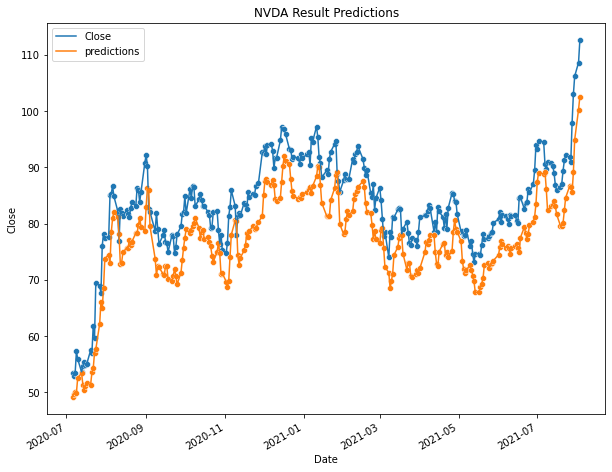

In [92]:
p.plot_test_result_graph()

<ipython-input-87-eb19b5bf9d4d>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.train_result['predictions'] = self.train_predictions


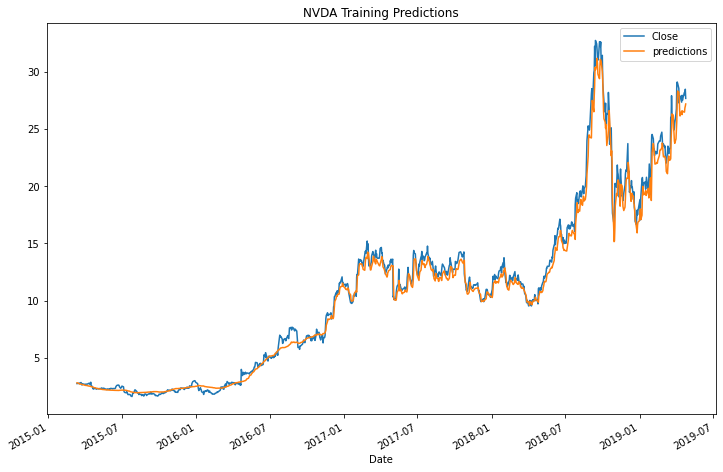

In [93]:
p.plot_train_result_graph()

In [94]:
p.ticker

'NVDA'

[*********************100%***********************]  1 of 1 completed
                 Close  predictions
Date                               
2020-07-06   93.462502    86.315482
2020-07-07   93.172501    88.358995
2020-07-08   95.342499    89.103241
2020-07-09   95.752502    90.235583
2020-07-10   95.919998    91.468794
...                ...          ...
2021-07-28  144.979996   139.496731
2021-07-29  145.639999   136.466989
2021-07-30  145.860001   136.054352
2021-08-02  145.520004   135.828252
2021-08-03  147.360001   136.531940

[273 rows x 2 columns]
MSE is: 63.98647445722549


<ipython-input-87-eb19b5bf9d4d>:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_result['predictions'] = self.test_predictions


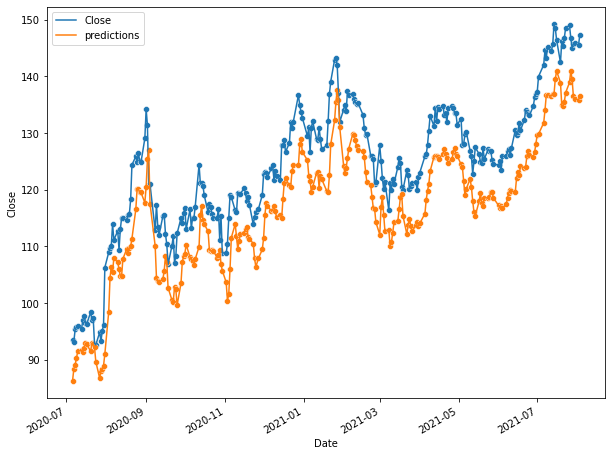

In [95]:
p.predict('AAPL')

[*********************100%***********************]  1 of 1 completed
                 Close  predictions
Date                               
2020-07-06  197.759995   186.624428
2020-07-07  194.199997   189.324158
2020-07-08  195.070007   188.289634
2020-07-09  192.210007   185.689014
2020-07-10  192.550003   184.361264
...                ...          ...
2021-07-28  246.940002   240.256565
2021-07-29  247.919998   237.456290
2021-07-30  246.389999   235.183255
2021-08-02  239.779999   234.058030
2021-08-03  237.089996   229.363349

[273 rows x 2 columns]
MSE is: 109.996864285454


<ipython-input-87-eb19b5bf9d4d>:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_result['predictions'] = self.test_predictions


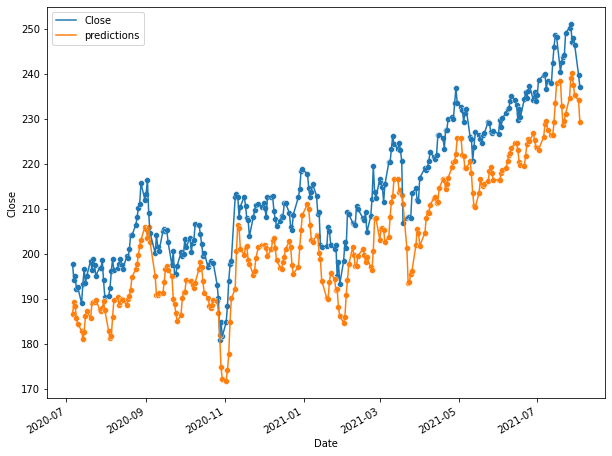

In [97]:
p.predict('V')

[*********************100%***********************]  1 of 1 completed
                 Close  predictions
Date                               
2020-07-06   98.392502    90.865371
2020-07-07   98.717499    92.762107
2020-07-08  102.160004    94.159412
2020-07-09  105.089996    96.104702
2020-07-10  104.792503    99.354909
...                ...          ...
2021-07-28  195.029999   179.451168
2021-07-29  196.619995   180.602077
2021-07-30  194.990005   182.096752
2021-08-02  197.500000   183.218966
2021-08-03  198.149994   183.381450

[273 rows x 2 columns]
MSE is: 106.52240610936337


<ipython-input-87-eb19b5bf9d4d>:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_result['predictions'] = self.test_predictions


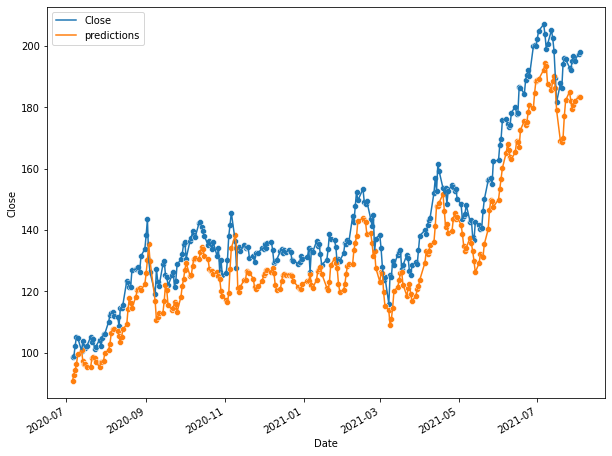

In [98]:
p.predict('NVDA')